In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Path to the directory containing your NHANES datasets
data_dir_1 = '/workspaces/Final-Year-Project/Data/2023/'

# Define the list of files and the variables of interest from each file
nhanes_files_variables = {
    'BMX_L.XPT': ['SEQN', 'BMXWAIST', 'BMXWT', 'BMXBMI', 'BMXARMC', 'BMXHIP'],
    'BPQ_L.XPT': ['SEQN', 'BPQ150', 'BPQ101D', 'BPQ020', 'BPQ080'],
    'FNQ_L.XPT': ['SEQN', 'FNQ440'],
    'HUQ_L.XPT': ['SEQN', 'HUQ010'],
    'MCQ_L.XPT': ['SEQN', 'MCQ160A'],
    'PAQ_L.XPT': ['SEQN', 'PAD810Q'],
    'SMQ_L.XPT': ['SEQN', 'SMAQUEX2', 'SMD630', 'SMD641'],
    'WHQ_L.XPT': ['SEQN', 'WHD020', 'WHD050'],
    'DEMO_L.XPT': ['SEQN', 'DMDYRUSR', 'RIDAGEYR'],
    'GHB_L.XPT': ['SEQN', 'LBXGH'],
    'GLU_L.xpt': ['SEQN', 'LBXGLU'],
}

# Load the required variables from each file
data_frames = {}

for file_name, variables in nhanes_files_variables.items():
    # Construct the file path
    file_path = data_dir_1 + file_name
    
    # Load the data from the .XPT file
    df = pd.read_sas(file_path)
    
    # Select only the relevant columns
    df = df[variables]
    
    # Store in the dictionary
    data_frames[file_name] = df

# Now, let's merge all dataframes on 'SEQN'
# Start by merging the first two files
merged_df = data_frames['BMX_L.XPT']

# Merge with the other datasets
for file_name, df in data_frames.items():
    if file_name != 'BMX_L.XPT':
        merged_df = pd.merge(merged_df, df, on='SEQN', how='outer')

# Display the info of the final merged dataframe
print(merged_df.info())







<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      11933 non-null  float64
 1   BMXWAIST  8190 non-null   float64
 2   BMXWT     8754 non-null   float64
 3   BMXBMI    8471 non-null   float64
 4   BMXARMC   8562 non-null   float64
 5   BMXHIP    6776 non-null   float64
 6   BPQ150    2969 non-null   float64
 7   BPQ101D   8498 non-null   float64
 8   BPQ020    8498 non-null   float64
 9   BPQ080    8498 non-null   float64
 10  FNQ440    8142 non-null   float64
 11  HUQ010    11933 non-null  float64
 12  MCQ160A   7807 non-null   float64
 13  PAD810Q   8139 non-null   float64
 14  SMAQUEX2  9015 non-null   float64
 15  SMD630    23 non-null     float64
 16  SMD641    273 non-null    float64
 17  WHD020    8486 non-null   float64
 18  WHD050    8486 non-null   float64
 19  DMDYRUSR  1875 non-null   float64
 20  RIDAGEYR  11933 non-null  fl

In [163]:
merged_df_cleaned = merged_df.dropna(subset=['LBXGH', 'LBXGLU'], how='all')

def categorize_diabetes(row):
    if (pd.notnull(row['LBXGH']) and row['LBXGH'] >= 6.5) or (pd.notnull(row['LBXGLU']) and row['LBXGLU'] >= 126):
        return 2
    
    elif (pd.notnull(row['LBXGH']) and 5.7 <= row['LBXGH'] < 6.5) or (pd.notnull(row['LBXGLU']) and 100 <= row['LBXGLU'] < 126):
        return 1
    else:
        return 0

# Apply the function to create the new 'Diabetes Status' column
merged_df_cleaned['Diabetes Status'] = merged_df_cleaned.apply(categorize_diabetes, axis=1)

# Drop the HbA1c (LBXGH) and FPG (LBXGLU) columns
merged_df_cleaned = merged_df_cleaned.drop(columns=['LBXGH', 'LBXGLU'])

# Display the info of the final dataframe
df = merged_df_cleaned
df.info()

# Display the first few rows to confirm
print(df.head())



<class 'pandas.core.frame.DataFrame'>
Index: 6717 entries, 0 to 11932
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SEQN             6717 non-null   float64
 1   BMXWAIST         6418 non-null   float64
 2   BMXWT            6640 non-null   float64
 3   BMXBMI           6626 non-null   float64
 4   BMXARMC          6548 non-null   float64
 5   BMXHIP           6364 non-null   float64
 6   BPQ150           2214 non-null   float64
 7   BPQ101D          6243 non-null   float64
 8   BPQ020           6243 non-null   float64
 9   BPQ080           6243 non-null   float64
 10  FNQ440           6002 non-null   float64
 11  HUQ010           6717 non-null   float64
 12  MCQ160A          5768 non-null   float64
 13  PAD810Q          5997 non-null   float64
 14  SMAQUEX2         6717 non-null   float64
 15  SMD630           22 non-null     float64
 16  SMD641           199 non-null    float64
 17  WHD020           6

/tmp/ipykernel_2857/3767201667.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_cleaned['Diabetes Status'] = merged_df_cleaned.apply(categorize_diabetes, axis=1)


In [165]:
missing_percentage = df.isnull().mean() * 100

columns_to_drop = missing_percentage[missing_percentage > 30].index

df = df.drop(columns=columns_to_drop)

df = df.dropna()

df.info()





<class 'pandas.core.frame.DataFrame'>
Index: 5416 entries, 0 to 11932
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SEQN             5416 non-null   float64
 1   BMXWAIST         5416 non-null   float64
 2   BMXWT            5416 non-null   float64
 3   BMXBMI           5416 non-null   float64
 4   BMXARMC          5416 non-null   float64
 5   BMXHIP           5416 non-null   float64
 6   BPQ101D          5416 non-null   float64
 7   BPQ020           5416 non-null   float64
 8   BPQ080           5416 non-null   float64
 9   FNQ440           5416 non-null   float64
 10  HUQ010           5416 non-null   float64
 11  MCQ160A          5416 non-null   float64
 12  PAD810Q          5416 non-null   float64
 13  SMAQUEX2         5416 non-null   float64
 14  WHD020           5416 non-null   float64
 15  WHD050           5416 non-null   float64
 16  RIDAGEYR         5416 non-null   float64
 17  Diabetes Status  5

In [167]:
df['Diabetes Status'].value_counts()

Diabetes Status
0    2521
1    2136
2     759
Name: count, dtype: int64

<Axes: >

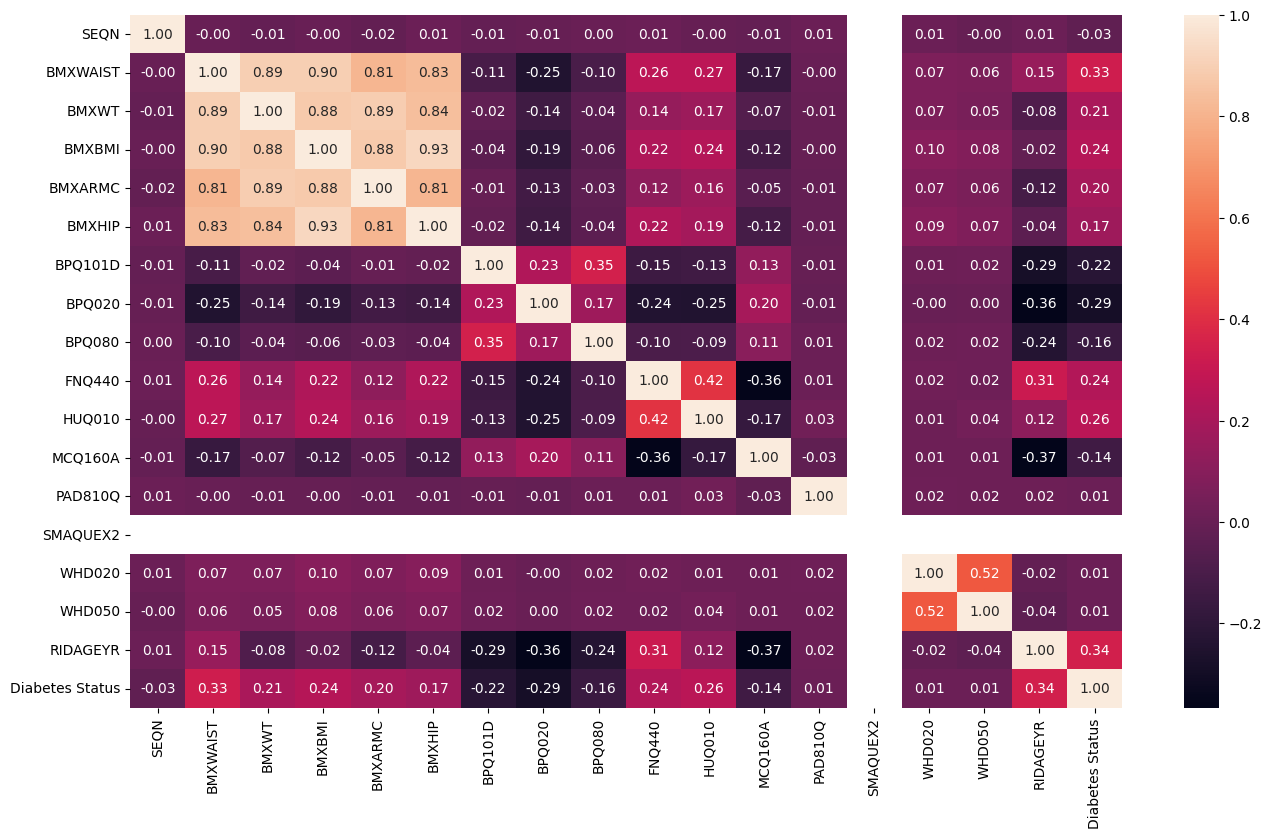

In [166]:
plt.figure(figsize=(16, 9))

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")


